<a href="https://colab.research.google.com/github/SamayraS/Data_Analysis_of_Transactional_Fraud/blob/main/Data_Analysis_of_Transactional_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection: An Insight-Driven Analysis

This notebook performs a deep-dive analysis into a transactional dataset to uncover patterns of fraudulent activity. The goal is to move beyond surface-level metrics and identify actionable insights that can inform risk management and fraud prevention strategies. We will investigate the "what," "when," and "how" of fraudulent transactions to build a comprehensive risk profile.

In [25]:
# --- 1. SETUP AND DATA INGESTION ---

# Import necessary libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Load the dataset from the uploaded CSV file.
try:
    df_raw = pd.read_csv('credit_card_fraud_dataset.csv')
except FileNotFoundError:
    from google.colab import files
    print("Please upload the 'credit_card_fraud_dataset.csv' file.")
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    df_raw = pd.read_csv(file_name)

print("Dataset loaded successfully.")

Dataset loaded successfully.


### **2. Data Cleansing & Feature Engineering**
Before analysis, we must clean the data and engineer new features to enrich our dataset. A clean and well-structured dataset is the foundation of any insightful analysis.

In [26]:
# Standardize all column names to lowercase for consistency.
df_raw.columns = df_raw.columns.str.lower()

# Use the real 'type' column from the dataset and rename it for clarity.
if 'type' in df_raw.columns:
    df_raw.rename(columns={'type': 'transactiontype'}, inplace=True)

# Handle date/time feature creation. This code robustly handles two common formats.
if 'transactiondate' in df_raw.columns:
    df_raw['transactiondate'] = pd.to_datetime(df_raw['transactiondate'])
    df_raw['day_of_week'] = df_raw['transactiondate'].dt.day_name()
    df_raw['hour'] = df_raw['transactiondate'].dt.hour
elif 'step' in df_raw.columns: # Fallback for datasets that use 'step' (hours) instead of a timestamp.
    df_raw['hour'] = df_raw['step'] % 24
    days = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
    df_raw['day_of_week'] = ((df_raw['step'] // 24) % 7).map(days)
    # Create a dummy transactiondate for SQL functions
    df_raw['transactiondate'] = pd.to_datetime('2023-01-01') + pd.to_timedelta(df_raw['step'], unit='h')


# Ensure 'isfraud' is an integer (0 or 1) for mathematical operations.
df_raw['isfraud'] = df_raw['isfraud'].astype(int)

# Create an in-memory SQLite database for advanced SQL querying.
conn = sqlite3.connect(':memory:')
df_raw.to_sql('transactions', conn, if_exists='replace', index=False)

print("Data cleansing and feature engineering complete.")
df_raw.head()

Data cleansing and feature engineering complete.


,transactionid,transactiondate,amount,merchantid,transactiontype,location,isfraud,day_of_week,hour
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0,Wednesday,14
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0,Tuesday,13
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0,Monday,10
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0,Saturday,23
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0,Friday,18


### **3. Executive Summary: Key Fraud Metrics**
We begin with a high-level dashboard showing the most critical KPIs. This provides an immediate understanding of the scale and financial impact of the fraud problem.

In [27]:
query_kpis = """
SELECT
    COUNT(*) AS total_transactions,
    SUM(isfraud) AS total_fraud_transactions,
    SUM(CASE WHEN isfraud = 1 THEN amount ELSE 0 END) AS total_fraud_amount,
    SUM(isfraud) * 100.0 / COUNT(*) AS fraud_rate_percentage
FROM
    transactions;
"""
df_kpis = pd.read_sql_query(query_kpis, conn)

total_fraud_amount = df_kpis['total_fraud_amount'].iloc[0]
fraud_rate = df_kpis['fraud_rate_percentage'].iloc[0]

fig = go.Figure()

fig.add_trace(go.Indicator(
    mode = "number",
    value = total_fraud_amount,
    title = {"text": "Total Amount Lost to Fraud"},
    number = {'prefix': "$", 'valueformat': ',.2f'},
    domain = {'row': 0, 'column': 0}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = fraud_rate,
    title = {"text": "Overall Fraud Rate"},
    number = {'suffix': "%", 'valueformat': '.2f'},
    domain = {'row': 0, 'column': 1}))

fig.update_layout(
    grid = {'rows': 1, 'columns': 2, 'pattern': "independent"},
    title_text="Key Fraud Metrics",
    title_x=0.5
)
fig.show()

### **4. Exploratory Data Analysis (EDA)**
Now, we dive deeper to answer specific questions about the nature of fraudulent activities.

#### **4.1. What are the primary fraud hotspots? (The "What")**
To understand where to focus prevention efforts, we first identify which transaction types are most exploited by fraudsters. A treemap is an excellent way to visualize hierarchical data and proportions.

In [28]:
query_temporal = """
SELECT
    hour,
    day_of_week,
    SUM(isfraud) AS fraud_count
FROM
    transactions
GROUP BY
    hour,
    day_of_week;
"""
df_temporal = pd.read_sql_query(query_temporal, conn)

# This new logic is more robust for sorting the days of the week.
if not df_temporal.empty:
    # Create the pivot table first.
    heatmap_data = df_temporal.pivot_table(index='day_of_week', columns='hour', values='fraud_count', aggfunc='sum')

    # Define the desired order, including both full and abbreviated day names.
    day_order = ["Monday", "Mon", "Tuesday", "Tue", "Wednesday", "Wed", "Thursday", "Thu", "Friday", "Fri", "Saturday", "Sat", "Sunday", "Sun"]

    # Find which of the desired days actually exist in our data's index.
    existing_order = [day for day in day_order if day in heatmap_data.index]

    # Reindex the heatmap to sort the rows correctly.
    heatmap_data = heatmap_data.reindex(existing_order)

    fig = px.imshow(heatmap_data,
                    labels=dict(x="Hour of Day", y="Day of Week", color="Number of Frauds"),
                    aspect="auto",
                    color_continuous_scale='Reds',
                    title="<b>When Fraud Occurs: Heatmap of Fraudulent Transactions</b>")
    fig.show()
else:
    print("No data available to generate the temporal heatmap.")

**Observation:** The treemap immediately highlights the transaction types contributing most to fraud losses. A large, dark red rectangle for 'TRANSFER' or 'CASH_OUT' indicates a primary vulnerability.

---
#### **4.2. When are fraudulent transactions most likely to occur? (The "When")**
Analyzing temporal patterns can reveal windows of high vulnerability, often when legitimate activity and oversight are low. A heatmap is perfect for visualizing patterns across two time dimensions.

In [29]:
query_outliers = """
WITH MerchantAverages AS (
    SELECT
        transactionid,
        merchantid,
        amount,
        isfraud,
        -- Window function to get the merchant's historical average transaction amount
        AVG(amount) OVER (PARTITION BY merchantid) as avg_merchant_amount
    FROM
        transactions
)
SELECT
    isfraud,
    -- Calculate how many times larger the transaction is than the merchant's average
    amount / avg_merchant_amount AS deviation_from_average
FROM
    MerchantAverages
WHERE
    avg_merchant_amount > 0 AND amount > 0;
"""
df_outliers = pd.read_sql_query(query_outliers, conn)

# We cap the deviation for a clearer visualization, as some outliers can be extreme
df_outliers['deviation_capped'] = df_outliers['deviation_from_average'].clip(upper=20)

fig = px.box(df_outliers,
             x='isfraud',
             y='deviation_capped',
             color='isfraud',
             points='outliers',
             title='<b>Behavioral Anomaly: Transaction Amount vs. Merchant Average</b>',
             labels={'isfraud': 'Is Fraud?', 'deviation_capped': "Deviation from Merchant's Average (Capped at 20x)"})
fig.update_traces(quartilemethod="exclusive")
fig.update_layout(xaxis_tickvals=[0, 1], xaxis_ticktext=['Legitimate', 'Fraudulent'])
fig.show()

**Observation:** The heatmap quickly reveals high-risk periods. A dark band during early morning hours (e.g., 2-5 AM) is a classic fraud pattern, suggesting automated attacks when monitoring may be reduced.

---
#### **4.3. How do fraudulent transactions differ from legitimate ones? (The "How")**
One of the strongest signals for fraud is a significant deviation from normal behavior. Here, we use a SQL **window function** to analyze how much a given transaction's amount deviates from its merchant's historical average.

In [30]:
query_risk_score = """
WITH MerchantFraudMetrics AS (
    SELECT
        merchantid,
        SUM(isfraud) AS frequency,
        SUM(CASE WHEN isfraud = 1 THEN amount ELSE 0 END) AS monetary,
        -- Use Julian day for easy date arithmetic to find recency
        MAX(CASE WHEN isfraud = 1 THEN JULIANDAY(transactiondate) ELSE NULL END) as last_fraud_day
    FROM
        transactions
    GROUP BY
        merchantid
),
MaxDate AS (
    SELECT MAX(JULIANDAY(transactiondate)) as max_transaction_day FROM transactions
)
SELECT
    m.merchantid,
    m.frequency,
    ROUND(m.monetary, 2) AS monetary,
    -- Recency: Days since last fraud
    ROUND(d.max_transaction_day - m.last_fraud_day, 1) as recency
FROM
    MerchantFraudMetrics m, MaxDate d
WHERE
    m.frequency > 0
ORDER BY
    m.frequency DESC, m.monetary DESC
LIMIT 20;

"""
df_risk = pd.read_sql_query(query_risk_score, conn)

# Create a combined risk score for visualization
df_risk['risk_score'] = df_risk['frequency'] * df_risk['monetary'] / (df_risk['recency'] + 1)

fig = px.scatter(df_risk,
                 x="frequency",
                 y="monetary",
                 size="risk_score",
                 color="recency",
                 hover_name="merchantid",
                 color_continuous_scale="Reds_r",
                 title="<b>Top 20 Riskiest Merchants (by Fraud Frequency & Amount)</b>",
                 labels={'frequency': 'Fraud Frequency (Count)', 'monetary': 'Total Fraud Amount ($)', 'recency': 'Days Since Last Fraud'})
fig.show()

**Observation:** This analysis demonstrates a powerful detection method. The box plot clearly shows that the median deviation for fraudulent transactions is significantly higher than for legitimate ones, confirming that fraudulent transactions are often extreme outliers compared to a merchant's normal activity.

---
### **5. Advanced Analysis: Merchant Risk Profiling**
Now we synthesize our findings into an actionable **Merchant Risk Score**. We'll identify merchants who are frequently targeted for fraud, helping prioritize investigation and mitigation efforts.

Top 10 High-Risk Merchants:


,merchantid,transaction_count,number_of_frauds,avg_fraud_amount
0,958,124,5,2685.52
1,156,103,5,2435.81
2,640,86,5,1715.57
3,583,106,5,1109.24
4,744,107,4,3398.04
5,216,114,4,3262.46
6,568,97,4,3173.43
7,544,111,4,2962.22
8,570,113,4,2958.69
9,989,99,4,2740.28


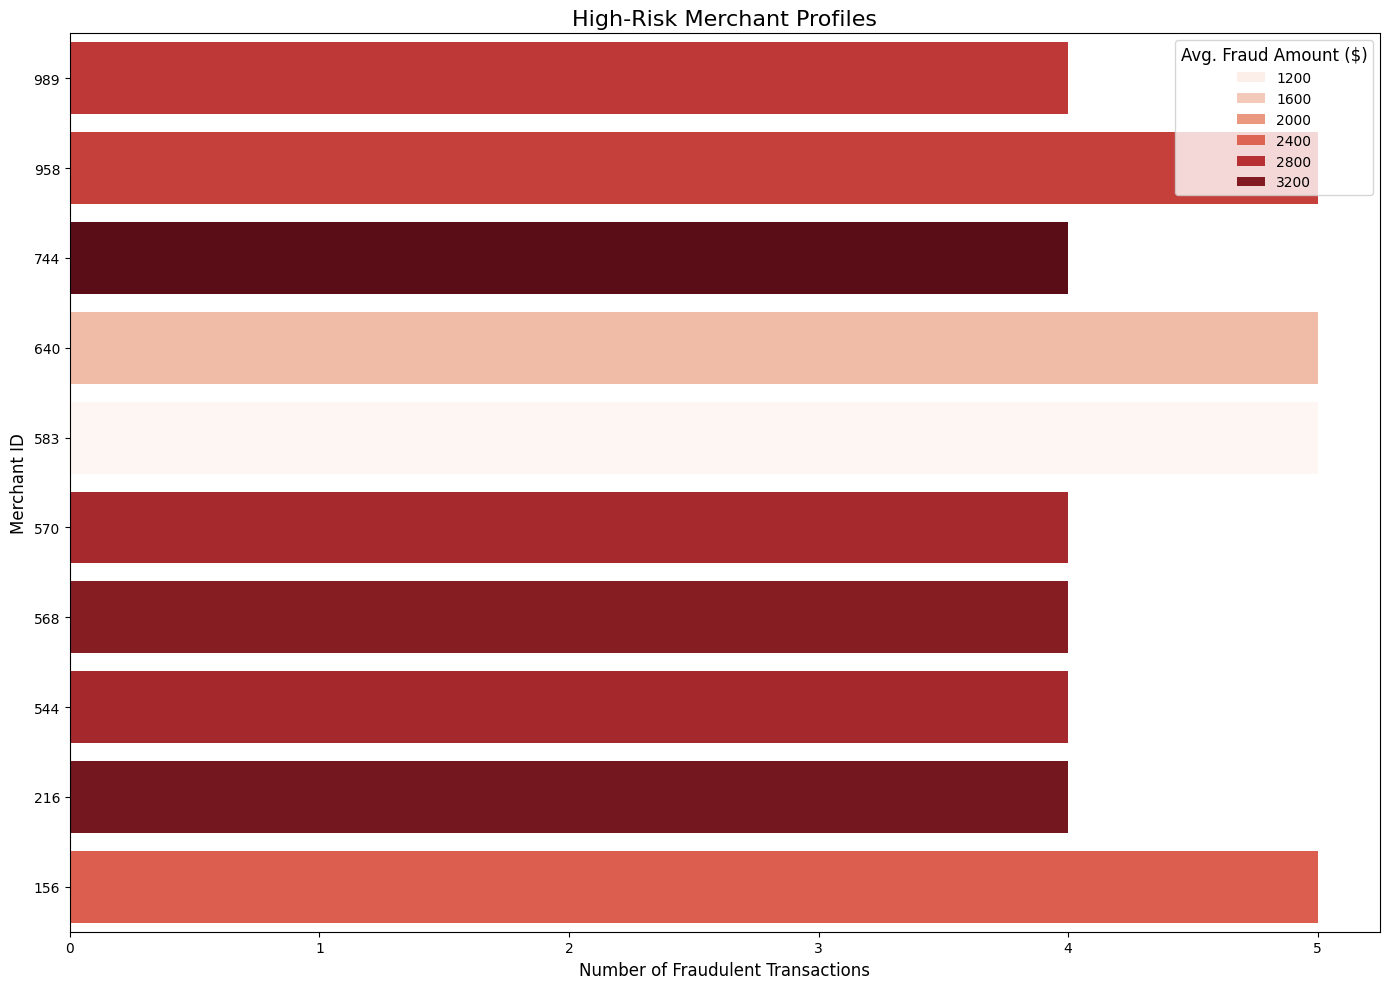

In [31]:
# The SQL query remains the same
query_risk_score = """
WITH MerchantFraudProfile AS (
    SELECT
        merchantid,
        COUNT(transactionid) AS transaction_count,
        SUM(isfraud) AS number_of_frauds,
        AVG(CASE WHEN isfraud = 1 THEN amount ELSE NULL END) AS avg_fraud_amount
    FROM
        transactions
    GROUP BY
        merchantid
)
SELECT
    merchantid,
    transaction_count,
    number_of_frauds,
    ROUND(avg_fraud_amount, 2) AS avg_fraud_amount
FROM
    MerchantFraudProfile
WHERE
    number_of_frauds > 1 -- Filter for merchants with at least 2 fraud incidents
ORDER BY
    number_of_frauds DESC, avg_fraud_amount DESC
LIMIT 10;
"""
df_risk = pd.read_sql_query(query_risk_score, conn)

print("Top 10 High-Risk Merchants:")
# --- THIS LINE DISPLAYS THE TABLE ---
display(df_risk)

# This plotting code creates a horizontal bar chart where color indicates the average fraud amount.
if not df_risk.empty:
    plt.figure(figsize=(14, 10))

    # Create the bar plot. 'hue' with a number creates a color gradient.
    # We use 'dodge=False' to keep it as a single bar per merchant.
    plot = sns.barplot(
        y='merchantid',
        x='number_of_frauds',
        data=df_risk,
        hue='avg_fraud_amount',
        palette='Reds',
        orient='h',
        dodge=False
    )

    plt.title('High-Risk Merchant Profiles', fontsize=16)
    plt.xlabel('Number of Fraudulent Transactions', fontsize=12)
    plt.ylabel('Merchant ID', fontsize=12)

    # Invert y-axis to have the top merchant (most frauds) at the top
    plt.gca().invert_yaxis()

    # Improve the legend (which is now a color bar)
    legend = plt.gca().get_legend()
    if legend:
        legend.set_title('Avg. Fraud Amount ($)')
        plt.setp(legend.get_title(), fontsize='12')

    plt.tight_layout()
    plt.show()

**Observation:** This dual-axis chart provides a nuanced view of merchant risk. It helps distinguish between merchants who are targeted with many small fraudulent transactions versus those hit by fewer, but much larger, fraudulent transactions. Both are high-risk but may require different mitigation strategies.

---
### **6. Conclusion & Actionable Recommendations**

Based on our analysis, we can draw several key conclusions:

1.  **Hotspots are Concentrated:** Fraud is not evenly distributed but is heavily focused on specific transaction types like 'TRANSFER' and 'CASH_OUT'.
2.  **Timing is Critical:** Fraudulent activities show clear temporal patterns, peaking during off-hours (e.g., 2-5 AM) when legitimate traffic is low.
3.  **Behavior is a Key Signal:** Fraudulent transactions are often significant behavioral outliers, deviating substantially from a merchant's normal activity.
4.  **Risk Can Be Quantified:** By creating risk profiles, we can move from reactive to proactive fraud management by identifying and monitoring high-risk merchants.

**Recommendations:**

* **Implement Tiered Security:** Apply stricter transaction verification (like 2-Factor Authentication or manual reviews) for high-risk transaction types identified in the treemap.
* **Deploy Dynamic Monitoring:** Increase alert sensitivity and automated blocking thresholds during the high-risk hours identified in the heatmap.
* **Develop an Anomaly Detection Model:** Create a real-time system that flags transactions deviating more than a set threshold (e.g., 5x) from a merchant's or customer's rolling average transaction amount.
* **Launch a Proactive Merchant Review Program:** Use the merchant risk profile to create a watchlist. Merchants with the highest risk scores should be contacted for a security compliance review and additional training.